In [ ]:
from keras.models import Sequential,Model
from keras.optimizers import Adam, RSMprop
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,BatchNormalization, Flatten
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.vis_utils import plot_model
from keras.layers.convolutional import Conv1D,MaxPooling1D 
from keras.layers.merge import concatenate
from tensorflow.keras import regularizers

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
!pip install tensorflow==2.3.0
!pip install keras==2.4.3

In [ ]:
import tensorflow as tf
tf.__version__

'2.3.0'

In [ ]:
from sklearn.metrics import classification_report

# Cargando la data

In [ ]:
df = pd.read_csv("/content/data_final (7) (1).csv")
d2 = pd.read_csv("/content/nuevos_registros (1).csv")
d3 = pd.read_csv("/content/nuevos_registros_v2.csv")
d2=d2[['label','text']]
d3=d3[['label','text']]

In [ ]:
df_final=pd.concat([df,d2,d3])
df_final.index=range(len(df_final))
df=df_final

In [ ]:
df_final.to_csv('nv_data.csv',header=True,index=False)

In [ ]:
df = pd.read_csv("/content/nv_data (1).csv")

In [ ]:
#Columnas del dataframe
df.columns


Index(['label', 'text'], dtype='object')

In [ ]:
#Cantidad de clases por Dataframe
df['label'].value_counts()


negative    90424
positive     7509
Name: label, dtype: int64

In [ ]:
df=df.drop_duplicates()
df['label'].value_counts()

negative    90333
positive     7498
Name: label, dtype: int64

In [ ]:
X = df.text #Separando la informacion en data
Y = df.label #Target
print(X[1]) #Visualizando un comentario sobre el COVID-19

el regimen de sanchinflas sera tan desalmado de quedarse con los pisos y bienes de los ancianos fallecidos


# Transformando los labels(y) para ML

In [ ]:
label_encoder = LabelEncoder() #Objeto del tipo Label Encoder
Y = label_encoder.fit_transform(Y) # Codificando el target en una lista
print(Y)
xY = to_categorical(Y)#Codificando el target de lista a matrix
print(Y)
print(X,Y)

[0 0 0 ... 0 0 0]
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
0        urgente coronavirus se reportan 105 nuevos cas...
1        el regimen de sanchinflas sera tan desalmado d...
2        en los ultimos meses enfrento tensiones social...
3        cifra impensable 7006 casos de coronavirus en ...
4        esperan resultado de prueba por covid 19 de co...
                               ...                        
97928    la euroliga aplaza el alba berlin baskonia de ...
97929    vamo el indec de la salud anticipo coronavirus...
97930    aumentan los casos de coronavirus en la comuna...
97931    lopez miras afirma que la decision sobre el to...
97932    alguien sabe que paso con esto complicado tira...
Name: text, Length: 97831, dtype: object [[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]


# Train test split

In [ ]:
#Train test split de manera estratificada (80% train y 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y,stratify=Y, test_size=0.20)


In [ ]:
import numpy as np
np.save('Xtrain_v4',list(X_train))


In [ ]:
type(X_train)

pandas.core.series.Series

In [ ]:
#maximo numero de palabras unicas
max_words = len(set(" ".join(X_train).split()))
#cantidad maxima de caracteres en los tweets (tamaño)
max_len = X_train.apply(lambda x: len(x)).max()

print(max_len,max_words)

1890 58168


# Transformando los tweets(X) para ML

In [ ]:
tokenizer = Tokenizer(num_words=max_words)

In [ ]:
tokenizer.fit_on_texts(X_train)
#method calculates the frequency of each word in our corpus/messages.

In [ ]:
X_train

7775     fin del uribismo lo unico claro es que poco le...
66200    ando re triste y encima tengo coronavirus no p...
32601    coronavirus vuelve a arreciar en europa y se t...
32329    pfizer comienza a probar la vacuna contra el c...
41030    u 0001f392 cierra un aula en la escuela infant...
                               ...                        
56425    preocupa x empezar a gobernar no te alcanza co...
30719    coronavirus jujuy quedo bajo la modalidad de d...
9693     teorias de la conspiracion del coronavirus por...
12009                       dias en los que duplican casos
12959    AHORA mario abdo benitez recibio llamada del p...
Name: text, Length: 78264, dtype: object

In [ ]:
X_train_seq = tokenizer.texts_to_sequences(X_train)

In [ ]:
X_train_seq[4]

[7,
 8616,
 1027,
 16,
 3276,
 4,
 3,
 954,
 3079,
 30964,
 8,
 216,
 561,
 21,
 1,
 4439,
 644,
 19]

In [ ]:
len(X_train_seq)

78264

In [ ]:
len(X_train_seq[2])

11

In [ ]:
X_train_seq = sequence.pad_sequences(X_train_seq, maxlen=max_len)

In [ ]:
X_train_seq[1]

array([   0,    0,    0, ...,   22,    7, 3851], dtype=int32)

# Parametros

In [ ]:
num_class = 2
#optimizer = Adam(lr=0.00001, decay=0.0001)
optimizer=RMSprop(lr=0.0001)

# Definiendo la arquitectura LSTM

In [ ]:
#Voting  ==  1ML(PERRO) 2ML(GATO) 3ML(GATO)  1DL (GATO)     GATO 
#Max==         0.65       0.72      0.87       0.91          SUM()/4
#penultima extrer vectores caracteristicos y ML

In [ ]:
def define_model(length, vocab_size):
  inputs = Input(shape=(length,))
  embedding = Embedding(vocab_size, 100)(inputs)
  # channel 1
  conv1 = Conv1D(filters=32, kernel_size=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
  pool1 = MaxPooling1D(pool_size=2)(conv1)
  drop1 = Dropout(0.5)(pool1)
  batch1= BatchNormalization()(drop1)
  lstm1 = LSTM(100) (batch1)
  #flat1 = Flatten()(lstm1)
  # channel 2
  conv2 = Conv1D(filters=32, kernel_size=4, activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
  pool2 = MaxPooling1D(pool_size=2)(conv2)
  drop2 = Dropout(0.5)(pool2)
  batch2= BatchNormalization()(drop2)
  lstm2 = LSTM(100) (batch2)
  #flat2 = Flatten()(lstm2)
  # channel 3
  conv3 = Conv1D(filters=32, kernel_size=5, activation='relu',kernel_regularizer=regularizers.l2(0.01))(embedding)
  pool3 = MaxPooling1D(pool_size=2)(conv3)
  drop3 = Dropout(0.5)(pool3)
  batch3 = BatchNormalization()(drop3)
  lstm3 = LSTM(100) (batch3)
  #flat3 = Flatten()(lstm3)
 	# merge
  merged = concatenate([lstm1, lstm2, lstm3])
  # interpretation
  #dense1 = Dense(10, activation='relu')(merged)
  outputs = Dense(2, activation='sigmoid')(merged)
  model = Model(inputs=[inputs], outputs=outputs)
  return model

# Cargando la arquitectura LSTM

In [ ]:
model =  define_model(max_len, max_words)
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 1890)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1890, 100)    5816800     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 1888, 32)     9632        embedding_1[0][0]                
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 1887, 32)     12832       embedding_1[0][0]                
_______________________________________________________________________________________

# Compilando LSTM

In [ ]:
# funcion de perdida, optimizador y metrica de evaluacion
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy']) 

#  Entrenado el LSTM

In [ ]:
seqModel=model.fit(X_train_seq,Y_train,batch_size=128,epochs=10,
          validation_split=0.2,)#callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.0001)])

Epoch 1/10
490/490 [==============================] - 141s 287ms/step - loss: 1.0699 - accuracy: 0.9214 - val_loss: 0.6352 - val_accuracy: 0.9237
Epoch 2/10
490/490 [==============================] - 142s 289ms/step - loss: 0.4398 - accuracy: 0.9396 - val_loss: 0.3322 - val_accuracy: 0.9494
Epoch 3/10
490/490 [==============================] - 141s 289ms/step - loss: 0.2661 - accuracy: 0.9568 - val_loss: 0.2356 - val_accuracy: 0.9528
Epoch 4/10
490/490 [==============================] - 142s 290ms/step - loss: 0.1855 - accuracy: 0.9663 - val_loss: 0.1766 - val_accuracy: 0.9616
Epoch 5/10
490/490 [==============================] - 142s 289ms/step - loss: 0.1384 - accuracy: 0.9725 - val_loss: 0.1513 - val_accuracy: 0.9642
Epoch 6/10
490/490 [==============================] - 142s 290ms/step - loss: 0.1108 - accuracy: 0.9754 - val_loss: 0.1383 - val_accuracy: 0.9641
Epoch 7/10
490/490 [==============================] - 141s 288ms/step - loss: 0.0919 - accuracy: 0.9784 - val_loss: 0.1166 -

# Grafica del accuracy

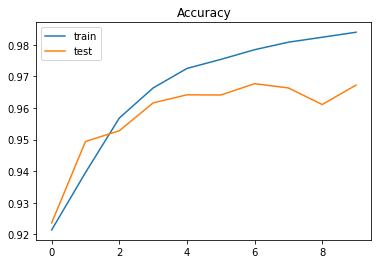

In [ ]:
plt.title('Accuracy')
plt.plot(seqModel.history['accuracy'], label='train')
plt.plot(seqModel.history['val_accuracy'], label='test')
plt.legend()

plt.show()


# Grafica del Loss

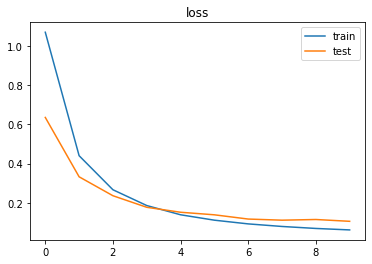

In [ ]:
plt.title('loss')
plt.plot(seqModel.history['loss'], label='train')
plt.plot(seqModel.history['val_loss'], label='test')
plt.legend()
plt.show()


In [ ]:
test_sequences = tokenizer.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
accr = model.evaluate(test_sequences_matrix,Y_test)

612/612 [==============================] - 32s 52ms/step - loss: 0.0941 - accuracy: 0.9722


In [ ]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 0.094
  Accuracy: 0.972


In [ ]:
pos=df[df['label']=='negative']['text']

In [ ]:
list(pos)[3]

'cifra impensable 7006 casos de coronavirus en colombia 314 fallecidos en norte de santander cuatro casos mas so'

In [ ]:
new_complaint = ['que felicidad que las personas se recuperen']
seq = tokenizer.texts_to_sequences(new_complaint)
print(seq)
padded = sequence.pad_sequences(seq, maxlen=max_len)
print (padded)
pred = model.predict(padded)

labels = ['neg','posi',]
print(pred, labels[np.argmax(pred)])

[[6, 4000, 6, 15, 46, 14, 25412]]
[[    0     0     0 ...    46    14 25412]]
[[0.02186556 0.97825867]] posi


In [ ]:
model.save('modelmultichannel_v3.h5', include_optimizer=True)
import io, json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer_multichannel.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
9.9997008e-01

0.99997008

In [ ]:
plt.title('Loss')
plt.plot(model['loss'], label='train')
plt.plot(model.history['val_loss'], label='test')
plt.legend()
plt.show();

In [ ]:
y_pred=model.predict(test_sequences_matrix, batch_size=200, verbose=2)

#y_pred=np.round(y_pred)
#report = classification_report(test_sequences_matrix, y_pred.round())

98/98 - 12s


In [ ]:
test_sequences_matrix

array([[   0,    0,    0, ...,  140,   55,  157],
       [   0,    0,    0, ...,    4,  103,  206],
       [   0,    0,    0, ..., 9448,    9, 1180],
       ...,
       [   0,    0,    0, ...,  969,    4, 1740],
       [   0,    0,    0, ...,  187,   10,    5],
       [   0,    0,    0, ..., 1670,    7,   37]], dtype=int32)

In [ ]:
report = classification_report(Y_test, y_pred.round())
print(report)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     18067
           1       0.86      0.76      0.81      1500

   micro avg       0.97      0.97      0.97     19567
   macro avg       0.92      0.88      0.90     19567
weighted avg       0.97      0.97      0.97     19567
 samples avg       0.97      0.97      0.97     19567



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
Y_test[0,0],Y_test[0,1]
Y_test

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [ ]:
def change(array):
  dat=[]
  for i in range(len(Y_test)):
    if Y_test[i,0]==1:
      dat.append(0)
    elif Y_test[i,0]==0:
      dat.append(1)
  return dat





In [ ]:
len(change(Y_test))

19567

In [ ]:
from sklearn.metrics import confusion_matrix
R=confusion_matrix( change(Y_test),  change(y_pred.round()))

In [ ]:
data = {'y_Actual': change(Y_test)   ,
        'y_Predicted': change(y_pred.round())
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])


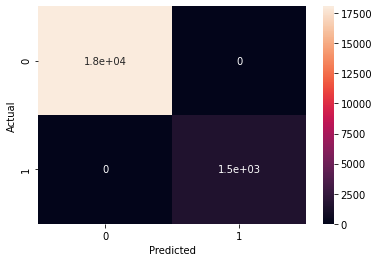

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(confusion_matrix, annot=True)
plt.show()

In [ ]:
import io, json
tokenizer_json = tokenizer.to_json()
with io.open('tokenizer_multichannel.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(tokenizer_json, ensure_ascii=False))

In [ ]:
#y_pred=model.predict(X_test_seq, batch_size=200, verbose=2)
report = classification_report(test_sequences_matrix, y_pred.round())
print(report)

In [ ]:
y_pred

In [ ]:
report = classification_report(test_sequences_matrix, y_pred)

NameError: ignored

In [ ]:
'''
model = Sequential()
    
model.add(Embedding(max_words, 100, input_length=max_len))

model.add(LSTM(256))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
    
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dropout(0.5))
    
model.add(Dense(num_class, activation='softmax'))
  

    
model.summary()
    '''
    
    

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report  
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(X_test, batch_size=32)
print(classification_report(Y_test.argmax(axis=1), accr.argmax(axis=1), target_names=['positive','negative'])) 

In [ ]:
learning_rate = 0.001
optimizer = SGD(learning_rate)

model.compile(optimizer= SGD(lr=0.00001, momentum=0.9),
              loss='categorical_crossentropy',#
              metrics=['accuracy'])
verbose = 1
epochs = 100
batch_size = 128
validation_split = 0.2

print("Trainning Model ...\n")

history1 = model.fit(
    X_train_seq,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    verbose=verbose,
    validation_split=validation_split,)

In [ ]:
model1

In [ ]:
from keras.preprocessing.text import Tokenizer
tok = Tokenizer()


In [ ]:
tok.fit_on_texts(["this comment is not toxic"]) 


In [ ]:
 
print(tok.texts_to_sequences(["this comment is not toxic"])) 
print(tok.texts_to_sequences(["this very long comment is not toxic"]))
print(tok.texts_to_sequences(["hello my name is jhonatan"]))

In [ ]:
model.save_weights('my_model_weights.h5')

In [ ]:
from keras.models import load_model


In [ ]:
model.load_weights('my_model_weights.h5')